# Task : Classify medical transcriptions by subspecialty of medicine.

In [1]:
# Importing all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from preprocess import sanitize_text, extract_entities, lemmatize_text

## Data preparation and preprocessing
- Load the dataset
- Selecting the appropriate colums and removing redundant data and missing values
- Removing noise from the text(sanitize_text), lemmatize (lemmatize_text - WordNetLemmatizer) , extract medical entites (extract_entities - using scispacy library)

In [2]:
# Load the dataset
path_to_file = "medical-transcripts/mtsamples.csv"
clinical_text_df = pd.read_csv(path_to_file)

In [3]:
# Update the values in the 'medical_specialty' column where 'Neurosurgery' is present to 'Neurology'
clinical_text_df.loc[
    clinical_text_df.medical_specialty == " Neurosurgery", "medical_specialty"
] = " Neurology"

# Update the values in the 'medical_specialty' column where 'Nephrology' is present to 'Urology'
clinical_text_df.loc[
    clinical_text_df.medical_specialty == " Nephrology", "medical_specialty"
] = " Urology"

# Filter the 'clinical_text_df' DataFrame to remove rows where the 'transcription' column is null
clinical_text_df = clinical_text_df[clinical_text_df["transcription"].notna()]

In [4]:
# Select the 'transcription' and 'medical_specialty' columns from the 'clinical_text_df' DataFrame
data = clinical_text_df[["transcription", "medical_specialty"]]

# Apply lambda function to strip whitespace from the 'medical_specialty' column
data["medical_specialty"] = data["medical_specialty"].apply(lambda x: str.strip(x))

/var/folders/gs/17ny57n91l9fsfm7mcs1t_840000gn/T/ipykernel_48426/2738496663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["medical_specialty"] = data["medical_specialty"].apply(lambda x: str.strip(x))


In [5]:
# List of columns to include - reasoning given in data_exploration.py
columns_to_include = [
    "Cardiovascular / Pulmonary",
    "Neurology",
    "Urology",
    "Radiology",
    "Psychiatry / Psychology",
    "Pediatrics - Neonatal",
    "Orthopedic",
    "Ophthalmology",
    "Obstetrics / Gynecology",
    "Hematology - Oncology",
    "Gastroenterology",
    "ENT - Otolaryngology",
]

# Filter the 'data' DataFrame to include only rows where 'medical_specialty' is in the specified columns
data = data[data["medical_specialty"].isin(columns_to_include)]

In [6]:
# Apply the 'extract_entities' function to extract entities from the 'transcription' column
data["transcription"] = data["transcription"].apply(extract_entities)

# Apply the 'lemmatize_text' function to lemmatize the 'transcription' column
data["transcription"] = data["transcription"].apply(lemmatize_text)

# Apply the 'sanitize_text' function to sanitize the 'transcription' column
data["transcription"] = data["transcription"].apply(sanitize_text)

## Feature extraction and dimensionality reduction

- For feature extraction, TfidfVectorizer has been used. Since, the dataset is imbalanced its prefferable to use TF-IDF. 
- PCA has been used for performing dimensionality reduction

In [7]:
# Instantiate TfidfVectorizer with specified settings
vectorizer = TfidfVectorizer(
    analyzer="word",
    stop_words="english",
    ngram_range=(1, 3),
    max_df=0.75,
    min_df=5,
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True,
    max_features=1500,
)

# Apply TfidfVectorizer to convert text data into TF-IDF matrix representation
tfIdfMat = vectorizer.fit_transform(data["transcription"].tolist())

In [8]:
# Apply Principal Component Analysis (PCA) to reduce dimensionality while retaining 95% of the variance
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())

# Convert the 'medical_specialty' column to a list of labels
labels = data["medical_specialty"].tolist()

# Create a list of unique medical specialty categories
category_list = data.medical_specialty.unique()

## Handling class imbalance 
- To handle class imbalance SMOTE oversampling technique is used to handle class imbalance. 
- To avoid data leakge oversampling has been applied only on the test set. 

In [9]:
# Apply SMOTE oversampling technique to address class imbalance
smote_over_sample = SMOTE(sampling_strategy="minority")

# Convert the 'medical_specialty' column to a list of labels
labels = data["medical_specialty"].tolist()

# Split the data into training and testing sets, stratified based on labels
X_train, X_test, y_train, y_test = train_test_split(
    tfIdfMat_reduced, labels, stratify=labels, random_state=1
)

# Apply SMOTE oversampling to the training set
X_train, y_train = smote_over_sample.fit_resample(X_train, y_train)

print("Train_Set_Size:" + str(X_train.shape))
print("Test_Set_Size:" + str(X_test.shape))

Train_Set_Size:(1981, 749)
Test_Set_Size:(581, 749)


## Clasification model - training and testing
- A logistic regressor  has been used as the classifier. 

In [10]:
# Train Logistic Regression classifier with elasticnet penalty and saga solver,
# using l1_ratio of 0.5 and a random state of 1.
clf = LogisticRegression(
    penalty="elasticnet", solver="saga", l1_ratio=0.5, random_state=1
).fit(X_train, y_train)

# Predict the target variable for the test dataset using the trained classifier.
y_test_pred = clf.predict(X_test)

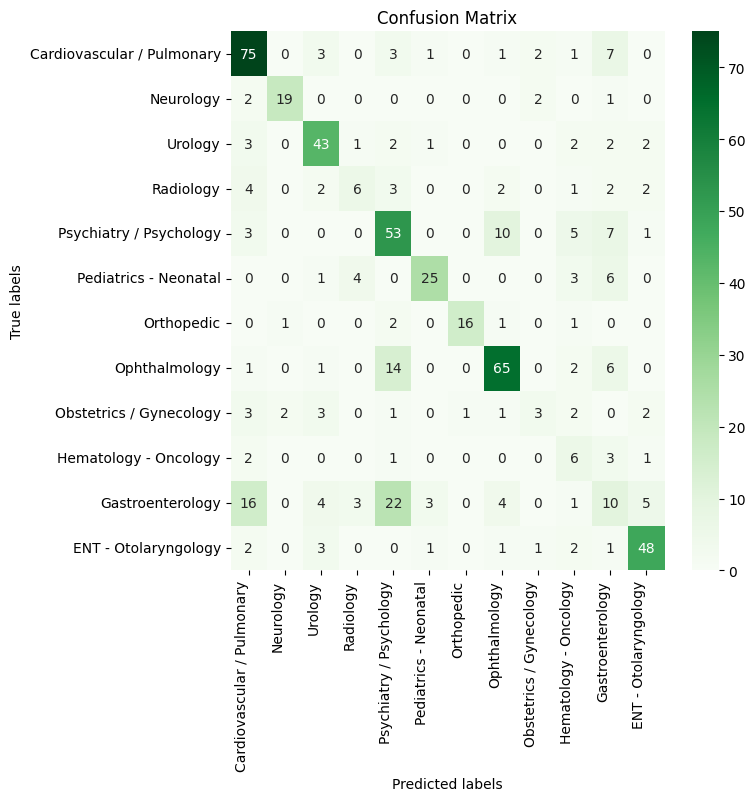

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.68      0.81      0.74        93
                 Neurology       0.52      0.67      0.59        79
                   Urology       0.79      0.81      0.80        59
                 Radiology       0.22      0.15      0.18        68
   Psychiatry / Psychology       0.23      0.46      0.31        13
     Pediatrics - Neonatal       0.38      0.17      0.23        18
                Orthopedic       0.76      0.73      0.75        89
             Ophthalmology       0.94      0.76      0.84        21
   Obstetrics / Gynecology       0.81      0.64      0.71        39
     Hematology - Oncology       0.43      0.27      0.33        22
          Gastroenterology       0.72      0.77      0.74        56
      ENT - Otolaryngology       0.86      0.79      0.83        24

                  accuracy                           0.64       581
                 macro avg       0.61      0.5

In [11]:
# Assign category_list to labels variable
labels = category_list

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a figure and axes for the heatmap
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)

# Generate the heatmap with annotated cells using the confusion matrix
sns.heatmap(cm, annot=True, cmap="Greens", ax=ax, fmt="g")

# Set labels, title, and ticks for the plot
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment="right")
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment="right")

# Display the plot
plt.show()

# Print the classification report
print(classification_report(y_test, y_test_pred, labels=category_list))

# Classwise results

# Conclusion
- Since the dataset is imbalanced, it is better to use `F1-score` to look at the accuracy of the model. The average `F1-score = 64%`.
              
- `Radiology`, `Obstetrics / Gynecology`, `Hematology - Oncology` have low amount of data, therefore the model accuracy for these classes is low. Adding more data will improve the accuracy for these classes.
- Within the transcriptions labeled as `Psychiatry / Psychology`, there are phrases related to alcohol use and its impact on the liver. The presence of references to the liver suggests a stronger association with `Psychiatry / Psychology` rather than `Gastroenterology`. This gives inccorect predictions. A solution to this problem could be to  incorporate additional features derived from domain knowledge. By doing this we can enhance the accuracy of the predictions.